In [175]:
import pandas as pd
smooth = pd.read_csv('./sensorlab_2018-10-13-07.33.54/accelerometer.csv')
bump = pd.read_csv('./sensorlab_2018-10-13-07.35.49/accelerometer.csv')
pothole = pd.read_csv('./sensorlab_2018-10-13-07.35.57/accelerometer.csv')
rugged = pd.read_csv('./sensorlab_2018-10-13-07.36.07/accelerometer.csv')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import itertools

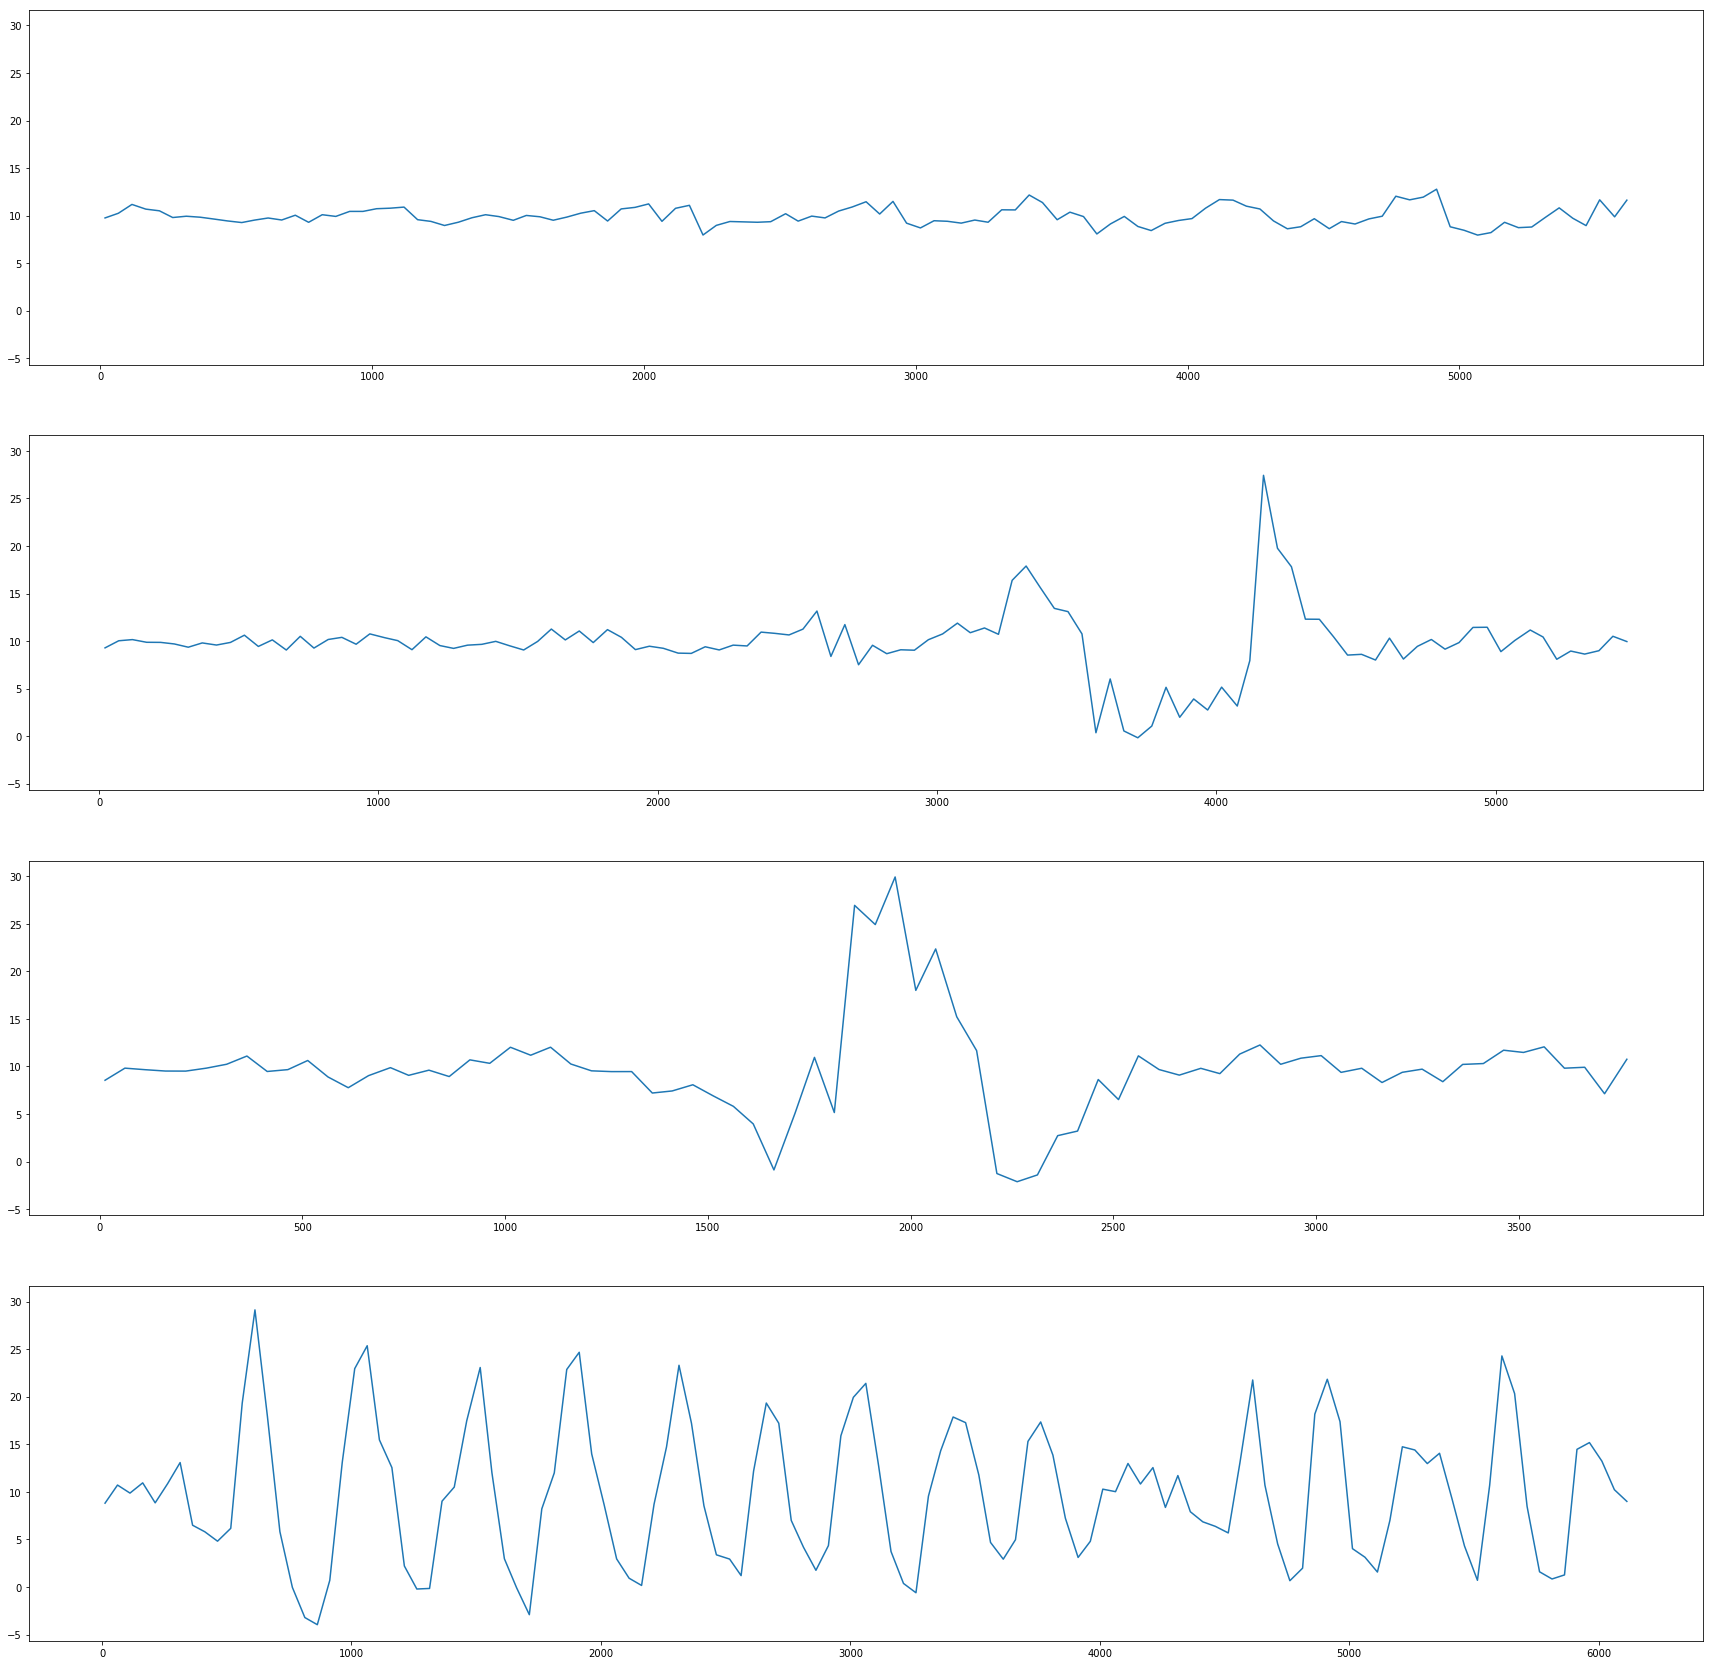

In [2]:
def plot_Device():
    fig, (ax0, ax1, ax2, ax4) = plt.subplots(nrows=4, figsize=(30, 30), sharey=True)
    ax0.plot(smooth.time, smooth.z)
    ax1.plot(bump.time, bump.z)
    ax2.plot(pothole.time, pothole.z)
    ax4.plot(rugged.time, rugged.z)
    plt.subplots_adjust(hspace=0.2)
    plt.show()
    
plot_Device()

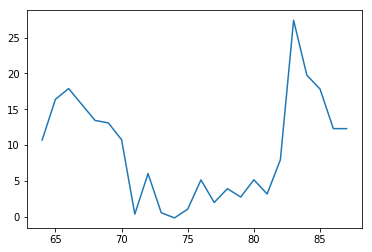

In [31]:
bump_c =bump.copy()
bump_c = bump_c[(bump_c.time > 3200) & (bump_c.time < 4400)]
bump_c.z.plot()

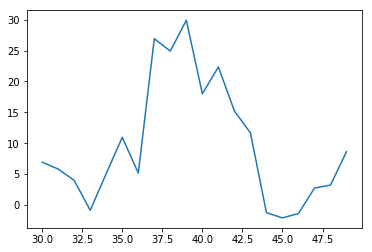

In [35]:
pot_c = pothole.copy()
pot_c = pot_c[(pot_c.time > 1500) & (pot_c.time < 2500)]
pot_c.z.plot()

In [136]:
def hp_filter(df, value=9.8, field="z", cutoff=4):
    """Returns new dataframe with field replaced with filtered values"""
    df1 = df.copy()
    df1.z = np.where(abs(df[field] - value)> cutoff, df[field], value)
    return df1

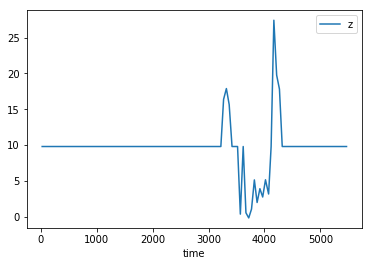

In [4]:
hole2 = hp_filter(bump)
hole2.plot(x='time', y='z')

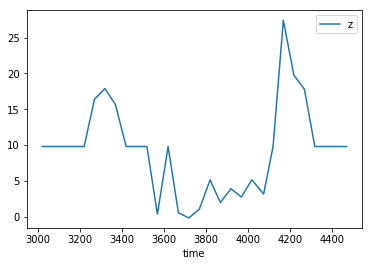

In [36]:
hole3 = hp_filter(bump)
hole3 = hole3[hole3['time'] > 3000]
hole3 = hole3[hole3['time'] < 4500]
hole3.plot(x='time', y='z')


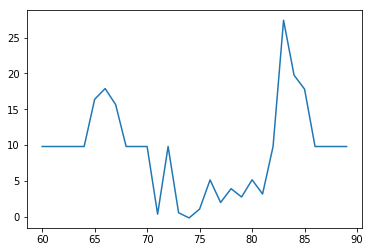

In [92]:
bump_spec = hp_filter(bump).z[60:90]
bump_spec.plot()

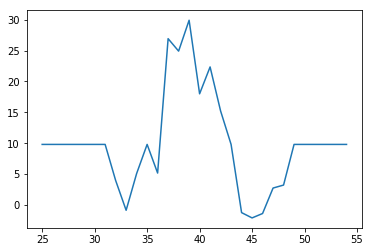

In [53]:
pothole_spec = hp_filter(pothole).z[25:55]
pothole_spec.plot()

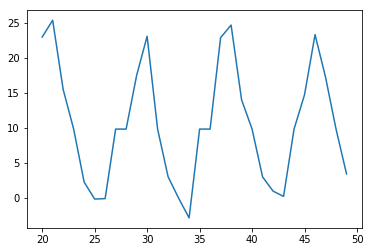

In [54]:
rugged_spec = hp_filter(rugged).z[20:50]
rugged_spec.plot()

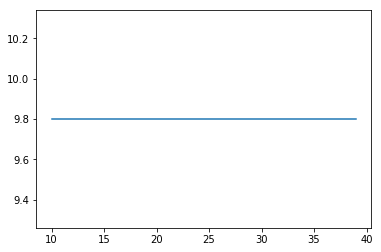

In [120]:
smooth_spec = hp_filter(smooth).z[10:40]
smooth_spec.plot()

In [83]:
resolution = 0.05
spec_duration = 30 * resolution
print(spec_duration)

1.5


In [144]:
# test_sample = hp_filter(smooth[10:40]).z
test_sample = rugged_spec
print((test_sample - smooth_spec).abs().mean())
print((test_sample - rugged_spec).abs().mean())
print((test_sample - pothole_spec).abs().mean())
print((test_sample - bump_spec).abs().mean())

7.222125
0.0
8.287032799999999
nan


In [127]:
from scipy.stats.stats import pearsonr
# print(test_sample.shape, smooth_spec.shape)
print(pearsonr(test_sample, smooth_spec))
print(pearsonr(test_sample, bump_spec))
print(pearsonr(test_sample, rugged_spec))
print(pearsonr(test_sample, pothole_spec))

(1.0, 0.0)
(7.524246135090231e-17, 1.0)
(3.492204482792356e-17, 1.0)
(1.5058028668127812e-16, 1.0)


In [135]:
with open('../collector/spec.json', 'w') as f:
    import json
    all_spec = {
        'smooth': smooth_spec.values.tolist(),
        'bump': bump_spec.values.tolist(),
        'rugged': rugged_spec.values.tolist(),
        'pothole': pothole_spec.values.tolist()
    }
    f.write(json.dumps(all_spec))

In [6]:
print(len(pothole))
time_extent = (pothole.time.max() - pothole.time.min())
print(time_extent)
sampling_rate = len(pothole)/time_extent
print(sampling_rate, "samples/ms")
print("An event happens over 2 second")
print("Number of samples that cover 1s: ", sampling_rate*2000)
print("Therefore need to consider 40-grams with let's say a stride of 5")
print("However, once an event is detected stop inferencing for let's say 4 seconds ")

76
3754
0.020245071923281833 samples/ms
An event happens over 2 second
Number of samples that cover 1s:  40.49014384656367
Therefore need to consider 40-grams with let's say a stride of 5
However, once an event is detected stop inferencing for let's say 4 seconds 


In [145]:
def slice_event_detector(df):
    pass

def stream_event_detector(df):
    sampling_rate = len(df)/(df.time.max() - df.time.min())
    sampling_window = int(sampling_rate * 4000)
    stride = sampling_window//4
    ignore_loops = sampling_window//stride * 4
    last_event = -1
    print("Time covered in each inference:", sampling_rate*sampling_window)
    print("Number of samples used in each inference:- ",sampling_window)
    print("Number of loops ignored after event is detected", ignore_loops)
    print("Stride", stride)
    for i in range(0, len(df), int(stride)):
        if (i + sampling_window) >= len(df):
            break
        slc = df.iloc[i : i + sampling_window]
        if last_event < 0 and slice_event_detector(slc):
            last_event = ignore_loops
        last_event -= 1
            
        
stream_event_detector(bump)

Time covered in each inference: 1.614975224811892
Number of samples used in each inference:-  80
Number of loops ignored after event is detected 16
Stride 20


In [146]:
newbump = pd.read_csv('./sensorlab_2018-10-14-02.48.30/accelerometer.csv')

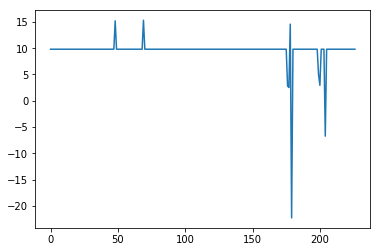

In [151]:
hp_filter(newbump).z.plot()

In [152]:
newpothole = pd.read_csv('./sensorlab_2018-10-14-02.55.01/accelerometer.csv')

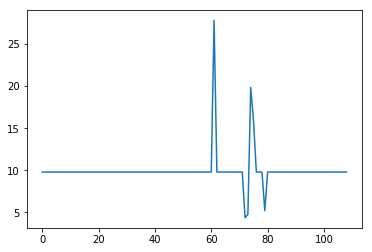

In [154]:
hp_filter(newpothole).z.plot()

In [155]:
newrugged = pd.read_csv('./sensorlab_2018-10-14-02.57.44/accelerometer.csv')

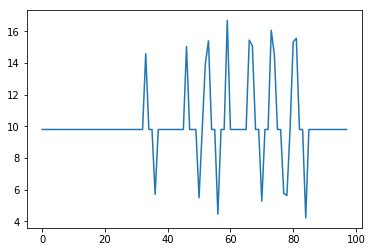

In [157]:
hp_filter(newrugged).z.plot()

In [179]:
x = hp_filter(newrugged).z
sign = np.sign(np.gradient(x))
[i[0] for i in itertools.groupby(sign[np.nonzero(sign)])]

[1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0,
 -1.0,
 1.0]

In [180]:
x = hp_filter(newbump).z
sign = np.sign(np.gradient(x))
[i[0] for i in itertools.groupby(sign[np.nonzero(sign)])]

[1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0, -1.0, 1.0]

In [211]:
x = hp_filter(newpothole).z
sign = np.sign(np.gradient(x))
sign
# [i[0] for i in itertools.groupby(sign[np.nonzero(sign)])]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  1.,  1., -1., -1.,  0.,
       -1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.])

In [195]:
data = pd.read_csv('./sensorlab_2018-10-14-03.12.31/accelerometer.csv')
info = ''
with open('./sensorlab_2018-10-14-03.12.31/_info.json') as f:
    info = json.loads(f.read())

(info['end'] - info['start']) / len(data)

50.46110325318246

In [212]:
g = np.gradient(hp_filter(data).z)
s = np.sign(g)

In [215]:
a = [1,2,5,4,5]
aa = np.array(a)
np.gradient(a)

array([1., 2., 1., 0., 1.])

In [225]:
a = np.array([1,2,3,3,4,5,5,6,1])
a & (a > 2)

array([0, 0, 1, 1, 0, 1, 1, 0, 0])

(array([2, 3, 4, 5, 6, 7]),)